In [1]:
%matplotlib inline

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

We have two different types of gauge: GPS gauges and pressure gauges. In the latter case, the observed variable is pressure. We deduce free surface elevation from pressure using hydrostatic assumptions:

$$p_{\mathrm{hydrostatic}}=\rho gh,$$

where $\rho\approx1030.0\,\mathrm{kg\,m}^{-3}$ is the density of sea water, $g\approx9.81\,\mathrm{m\,s}^{-2}$ is gravitational acceleration and $H$ is the height of the fluid column.

The height of the fluid column may be decomposed as

$$H=b + \eta,$$

where the bathymetry $b$ $[\mathrm m]$ is known and $\eta$ is the free surface displacement we seek.

_[These calculations are performed using_ `preproc.py`, _which outputs the_ `.dat` _files.]_

In [3]:
pressure_gauges = ('P02', 'P06', 'KPG1', 'KPG2', '21418')
gps_gauges = ('801', '802', '803', '804', '806')
gauges = pressure_gauges + gps_gauges
gauge_dict = {gauge: {} for gauge in gauges}

In [23]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
                
    interp = scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')
    init = interp(0.0)
    
    def shifted(tau):
        return interp(tau) - init
    
    return shifted

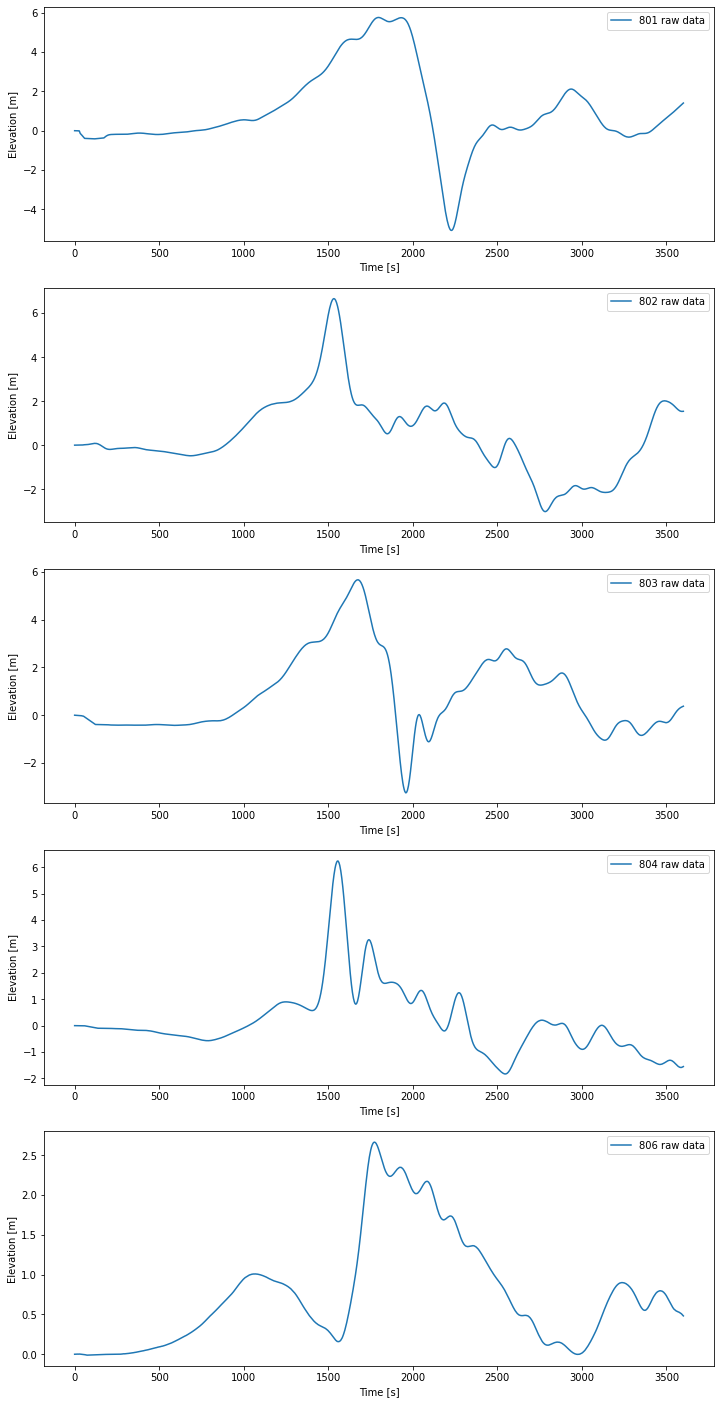

In [26]:
fig, axes = plt.subplots(nrows=len(gps_gauges), figsize=(12, 5*len(gps_gauges)))

times = np.linspace(0.0, 3600.0, 3601)
for i, gauge in enumerate(gps_gauges):
    ax = axes[i]
    
    gauge_dict[gauge]['interpolator'] = sampled_timeseries(gauge)
    for t in times:
        gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
    
    ax.plot(times, gauge_dict[gauge]['data'], label=gauge.upper() + ' raw data')
    ax.set_xlabel("Time [s]");
    ax.set_ylabel("Elevation [m]");
    ax.legend();

For the P02 and P06 pressure gauges, we also have free surface elevation data extracted from the figure in [Saito et al. 2011] using `PlotDigitizer`.

In [65]:
plot_digitizer = {}
plot_digitizer["P02"] = [
    0.00, 0.07, 0.12, 0.46, 0.85, 1.20, 1.55, 1.90, 2.25, 2.50, 2.80, 3.10, 3.90, 4.80,
    4.46, 2.25, -0.45, -0.17, -1.60, -0.82, -0.44, -0.26, -0.08, 0.13, 0.42, 0.71
]
plot_digitizer["P06"] = [
    0.00, 0.10, 0.30, 0.65, 1.05, 1.35, 1.65, 1.95, 2.25, 2.55, 2.90, 3.50, 4.50, 4.85,
    3.90, 1.55, -0.35, -1.05, -0.65, -0.30, -0.15, 0.05, 0.18, 0.35, 0.53, 0.74
]

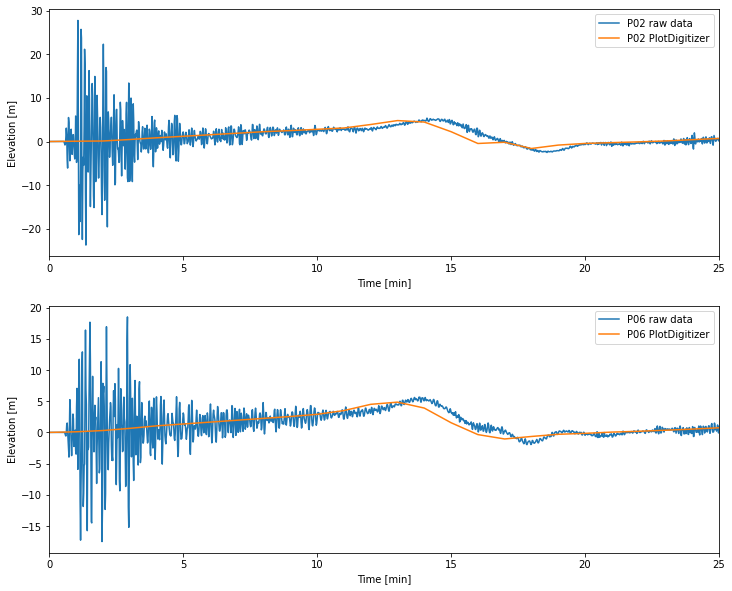

In [68]:
gauges = ("P02", "P06")

fig, axes = plt.subplots(nrows=len(gauges), figsize=(12, 5*len(gauges)))
for i, gauge in enumerate(gauges):
    ax = axes[i]
    
    gauge_dict[gauge]['data'] = []
    gauge_dict[gauge]['interpolator'] = sampled_timeseries(gauge, sample=1)
    for t in times:
        gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
    
    N = len(plot_digitizer[gauge])
    elev = np.array(gauge_dict[gauge]['data'])
    elev -= elev[1]
    elev[0] = 0
    ax.plot(times/60, elev, label=gauge.title() + ' raw data')
    ax.plot(range(N), plot_digitizer[gauge], label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    if N >= 1:
        ax.set_xlim([0, N-1])
    ax.legend();
plt.savefig("pressure_gauges_raw.png")

We see that there is a lot of noise in this data, especially near the start of the observation period.
It also looks like the raw data and `PlotDigitizer` are out of date.

Let's try sampling over windows and taking the average for a few different sample sizes.

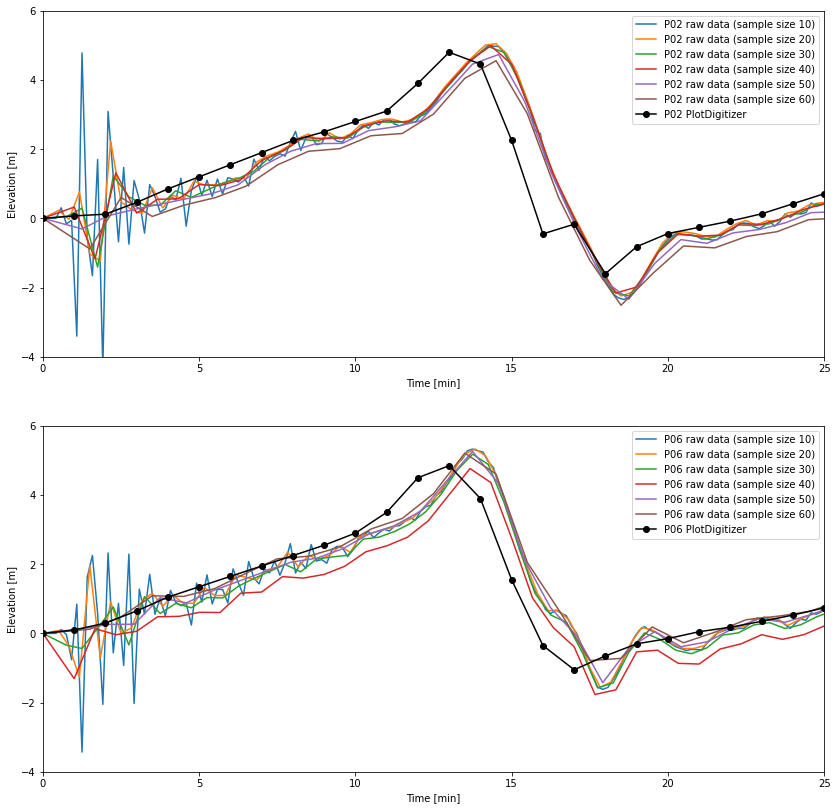

In [75]:
fig, axes = plt.subplots(nrows=len(gauges), figsize=(14, 7*len(gauges)))
for i, gauge in enumerate(gauges):
    ax = axes[i]
    N = len(plot_digitizer[gauge])
    for sample in range(10, 70, 10):
        
        gauge_dict[gauge]['interpolator'] = sampled_timeseries(gauge, sample=sample)
        gauge_dict[gauge]['data'] = []
        for t in times:
            gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
    
        elev = np.array(gauge_dict[gauge]['data'])
        elev = np.array([eta for eta, time in zip(elev, times)])
        elev -= elev[0]  # make them all start from zero
        ax.plot(times/60, elev, label='{:s} raw data (sample size {:d})'.format(gauge.title(), sample))
    ax.plot(range(N), plot_digitizer[gauge], marker='o', color='k', label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.set_xlim([0, N-1])
    ax.set_ylim([-4, 6])
    ax.legend();

It looks like the observations and the `PlotDigitizer` data are about one minute out of sync:

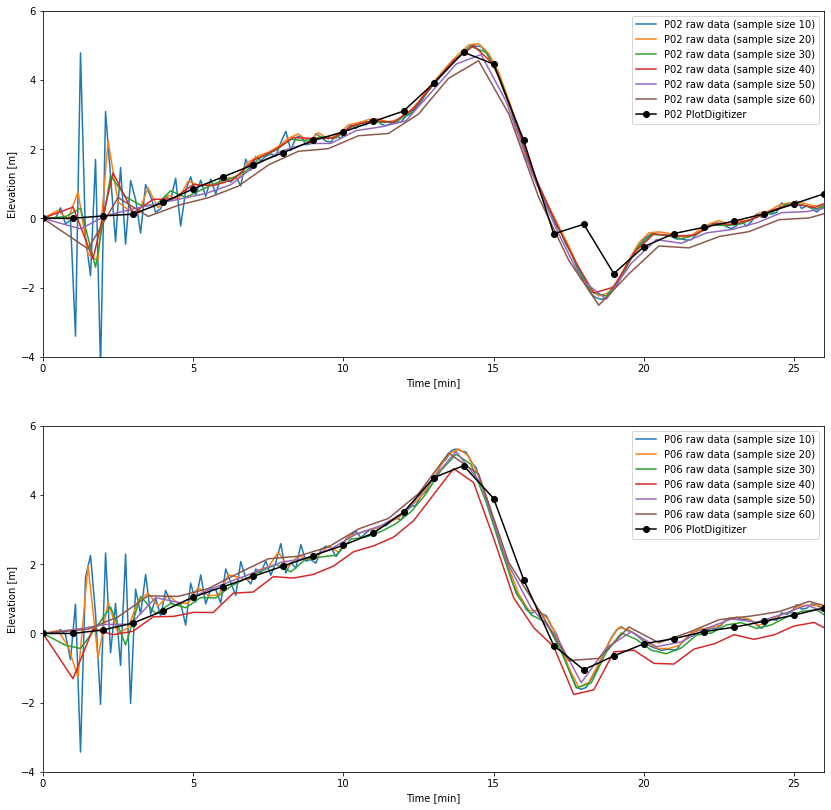

In [78]:
fig, axes = plt.subplots(nrows=len(gauges), figsize=(14, 7*len(gauges)))
for i, gauge in enumerate(gauges):
    ax = axes[i]
    plot_digitizer_ = [0.0, ]  # Push back a minute
    plot_digitizer_.extend(plot_digitizer[gauge])
    N = len(plot_digitizer_)
    for sample in range(10, 70, 10):
        
        gauge_dict[gauge]['interpolator'] = sampled_timeseries(gauge, sample=sample)
        gauge_dict[gauge]['data'] = []
        for t in times:
            gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
    
        elev = np.array(gauge_dict[gauge]['data'])
        elev = np.array([eta for eta, time in zip(elev, times)])
        elev -= elev[0]  # make them all start from zero
        ax.plot(times/60, elev, label='{:s} raw data (sample size {:d})'.format(gauge.title(), sample))
    ax.plot(range(N), plot_digitizer_, marker='o', color='k', label=gauge.title()+' PlotDigitizer')
    ax.set_xlabel("Time [min]");
    ax.set_ylabel("Elevation [m]");
    ax.set_xlim([0, N-1])
    ax.set_ylim([-4, 6])
    ax.legend();

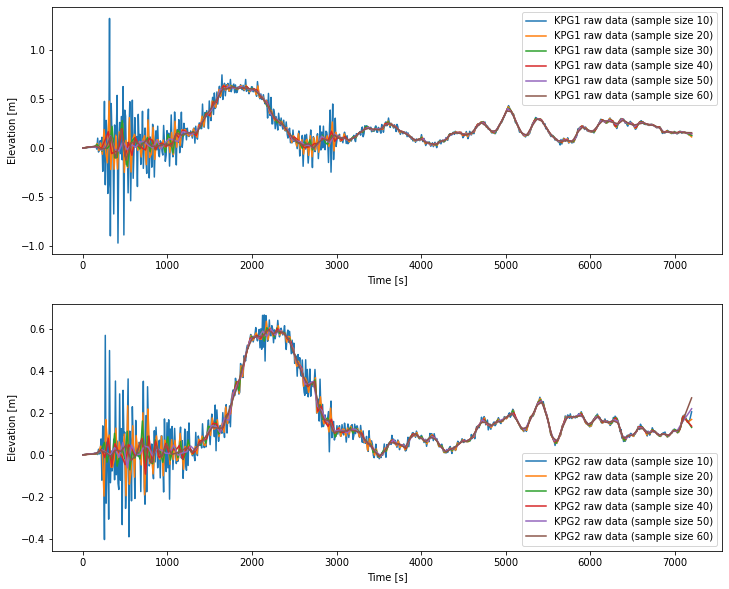

In [82]:
gauges = ("KPG1", "KPG2")
times = np.linspace(0.0, 7200.0, 7201)
fig, axes = plt.subplots(nrows=len(gauges), figsize=(12, 5*len(gauges)))
        
for i, gauge in enumerate(gauges):
    ax = axes[i]
    
    for sample in range(10, 70, 10):
        gauge_dict[gauge]['data'] = []
        gauge_dict[gauge]['interpolator'] = sampled_timeseries(gauge, sample=sample)
        for t in times:
            gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))
        
        ax.plot(times, gauge_dict[gauge]['data'], label='{:s} raw data (sample size {:d})'.format(gauge.upper(), sample))
    ax.set_xlabel("Time [s]");
    ax.set_ylabel("Elevation [m]");
    ax.legend();

In [61]:
gauges = ("21418", )
for gauge in gauges:
    gauge_dict[gauge]['data'] = []
    gauge_dict[gauge]['interpolator'] = sampled_timeseries(gauge, sample=1)
    for t in times:
        gauge_dict[gauge]['data'].append(gauge_dict[gauge]['interpolator'](t))

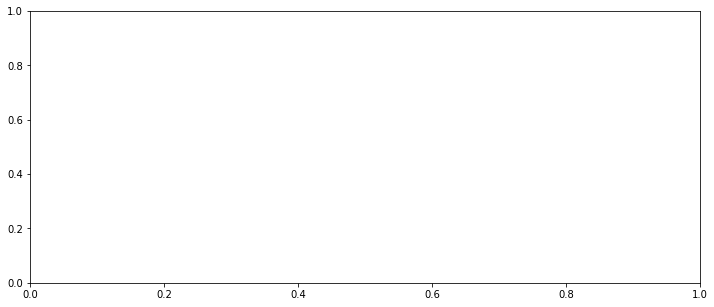

In [62]:
fig, axes = plt.subplots(nrows=len(gauges), figsize=(12, 5*len(gauges)))
for i, gauge in enumerate(gauges):
#     ax = axes[i]
    ax.plot(times, gauge_dict[gauge]['data'], label=gauge.upper() + ' raw data')
    ax.set_xlabel("Time [s]");
    ax.set_ylabel("Elevation [m]");
    ax.legend();

# FIXME: 21418 above
# TODO: MPG1 and MPG2
# TODO: VCM1 and VCM3